In [1]:
# !pip install auquan_toolbox
import numpy as np
import pandas as pd
# import backtester
import datetime
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

from datetime import timezone
import pytz

import copy

In [2]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [3]:
coin_list = cg.get_coins_list()

id_to_data = {}
for coin_data in coin_list:
    id_to_data[coin_data.pop('id')] = coin_data
ids = id_to_data.keys()
    

In [4]:
def to_timezone(dtobj, trg_tz):
    trg_tzobj = trg_tz if type(trg_tz) is str else pytz.timezone(trg_tz)
    return dtobj.astimezone(trg_tzobj)

def from_tmsp(tmsp, trg_tz, short=False):
    trg_tzobj = trg_tz if type(trg_tz)!=str else pytz.timezone(trg_tz)
    if not type(tmsp) is int:
        tmsp = tmsp.timestamp()
    tmsp = tmsp/1000 if short else tmsp
    return datetime.datetime.fromtimestamp(tmsp, trg_tzobj)
        
def get_loc_time():
    return datetime.datetime.now()
def get_utc_time():
    return datetime.datetime.utcnow()


In [5]:
def id_to_tmsp_seq(id, start_date, end_date):
    trg_tzobj = timezone.utc
    start_tmsp, end_tmsp = datetime.datetime(*start_date, tzinfo=trg_tzobj), datetime.datetime(*end_date, tzinfo=trg_tzobj)
    return cg.get_coin_market_chart_range_by_id(id=id, vs_currency=NAT_CURR, from_timestamp=start_tmsp, to_timestamp=end_tmsp)['prices']
def id_to_prices(id, start_date, end_date):
    prices = id_to_tmsp_seq(id, start_date, end_date)
    return np.array([price[1] for price in prices])


In [6]:
def id_to_tmsp_seq(id, start_date, end_date):
    trg_tzobj = timezone.utc
    start_tmsp, end_tmsp = datetime.datetime(*start_date, tzinfo=trg_tzobj).timestamp(), datetime.datetime(*end_date, tzinfo=trg_tzobj).timestamp()
    return cg.get_coin_market_chart_range_by_id(id=id, vs_currency=NAT_CURR, from_timestamp=start_tmsp, to_timestamp=end_tmsp)['prices']
def id_to_prices(id, start_date, end_date):
    prices = id_to_tmsp_seq(id, start_date, end_date)
    return np.array([price[1] for price in prices])


In [7]:
# COIN_COLS = ['id', 'symbol', 'name']
# df_coin_names = pd.DataFrame(coin_list, columns=['name'])

# coin_market = cg.get_coins_markets(vs_currency=NAT_CURR)
# df_market = pd.DataFrame(coin_market, columns=['id', 'current_price', 'high_24h', 'low_24h'])
# df_market.set_index('id', inplace=True)
# df_market

In [8]:
def plot_df(df, x_label='Time', y_label='Value', title=None):
    plt.clf()
    plt.figure(figsize=(15,7))
    plt.plot(df)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(df.columns)
    plt.title(title)
    plt.show()
    

def plot_series(series_seq, x_label='Time', y_label='Value', linestyles=None, colors=None, title=None):
    working_series_seq = copy.deepcopy(series_seq)
    
    for series in working_series_seq:
        series.index = [from_tmsp(ind, timezone.utc, short=True) for ind in series.index]
    
    plt.clf()
    plt.figure(figsize=(15,7))
    
    if linestyles==None:
        linestyles = ['-']*len(working_series_seq)
    if colors==None:
        colors = ['b']*len(working_series_seq)
        
    for series, linestyle, color in zip(working_series_seq, linestyles, colors):
        plt.plot(series, linestyle=linestyle, color=color)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(min([series.index[0] for series in working_series_seq]) , max([series.index[-1] for series in working_series_seq]))
    plt.legend([series.name for series in working_series_seq])
    plt.title(title)
    plt.show()

In [9]:
def clean_df(df, columns):
    for column in columns:
        df[column].fillna(method='ffill', inplace=True)
        df[column].fillna(method='bfill', inplace=True)
    return df

In [10]:

def id_to_df(id, start_date, end_date, norm=True, plot=False):
    market = id_to_tmsp_seq(id, start_date, end_date)
    tmsps, prices = list(zip(*market))
    
    df = pd.DataFrame(index=tmsps)
    
    df[id] = prices
    df.head()
    
    if norm:
        df = df/df.iloc[0]
    
    if plot:
        plot_df(df)
        
    return df

# def id_to_market_df(id, start_date, end_date, norm=True, plot=False):
    

In [11]:
def differentiate(series):
    series_d = series.diff()[1:]
    series_d.name = f'{series.name}_D'
    return series_d

def integrate(series):
    series_i = series.cumsum()
    series_i.name = f'{series.name}_I'
    return series_i

def eval_port(df, norm=True):
    port = df.sum(axis=1)
    port.name = 'port_val'
    
    if norm:
        port = port/port.iloc[0]
    return port

In [12]:
def daily_ret(series):
    series_dr = (series/series.shift(1) - 1)
    series_dr.name = f'{series.name}_DR'
    return series_dr

def cum_ret(series):
    series_cr = series/series.iloc[0] - 1
    series_cr.name = f'{series.name}_CR'
    return series_cr
    

In [13]:
def take_mean(series, plot=True):
    s_m = series.mean()
    series_m = pd.Series(s_m, index=series.index)
    series_m.name = f'{series.name}_M'
    
    if plot:
        plot_series([series, series_m], x_label='Time', y_label='Value', linestyles=[None, 'dashed'], colors=['b', 'r'], title=f"{series.name}+Mean vs. Time")
        
    return s_m

def take_roll_avg(series, window, plot=True):
    series_ma = series.rolling(window).mean()
    series_ma.fillna(method='bfill', inplace=True)
    series_ma.name = f'{series.name}_MA{window}'
    
    if plot:
        plot_series([series, series_ma], x_label='Time', y_label='Value', linestyles=[None, 'dashed'], colors=['b', 'r'], title=f"{series.name}+MA vs. Time")
    
    return series_ma

In [14]:
def sharpe_ratio(series_dr):
    adr, sddr = series_dr.mean(), series_dr.std()

    sr = np.sqrt(252)*adr/sddr # we use risk-free rate = 0
    
    return sr

In [15]:
def series_to_df_feats(series, ma_lookbacks, plot=False):
    df = series.to_frame()
    
    for lookback_wind in ma_lookbacks:
        series_w = take_roll_avg(series, lookback_wind, plot=False)
        df = df.join(series_w.to_frame())
        
    df = df.join(cum_ret(series))
    df = df.join(daily_ret(series))
    
    if plot:
        plot_df(df[list(df.columns)[:len(ma_lookbacks)+1]], title=f'{series.name} MAs vs. Time')
        
    return df
        
    

In [16]:
def test_stationarity(series, cutoff=0.01):
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(series)[1]
    if pvalue < cutoff:
        print(f'p-value = {pvalue} The series {series.name} is likely stationary.')
        return True
    else:
        print(f'p-value = {pvalue} The series {series.name} is likely non-stationary.')
        return False

In [17]:
def create_portfolio_from_ids(ids, start_date, end_date, norm_port=True):
    ref_id, asset_ids = ids[0], ids[1:]
    
    df = id_to_df(ref_id, start_date, end_date)
    df.columns = [ref_id]
    
    for asset_id in asset_ids:
        new_df = id_to_df(asset_id, start_date, end_date)
        new_df.columns = [asset_id]
        df = df.join(new_df)
        
    df = clean_df(df, df.columns[1:])
        
    ## Evaluate portfolio
    df['port_val'] = eval_port(df, norm=norm_port)
        
    return df
        
    

In [18]:
def is_coint(series_1, series_2):
    
    results = sm.OLS(series_2, series_1).fit()
    beta = results.params[series_1.name]

    Z = series_2 - beta * series_1

    is_stationary = test_stationarity(Z)
    
    if not is_stationary: return False
    
    if not is_stationary:
        return False
    else: ## cointegrate is series are not stationary
        return coint(series_1, series_2)
    

In [19]:
##################
## LOCAL DRIVER ##
##################

nat_tz = 'America/Los_Angeles'
nat_tzobj = pytz.timezone(nat_tz)

trg_tzobj = timezone.utc



start_date, end_date = (2010,9,1), (2020,9,1)

port_ids = ['bitcoin', 'dogecoin', 'ethereum', 'bolt']


NAT_CURR = 'usd'

ROLL_WIND = 14
LOOKBACKS = [7, 14, 30]


## Create portfolio dataframe
port_df = create_portfolio_from_ids(port_ids, start_date, end_date)


<Figure size 432x288 with 0 Axes>

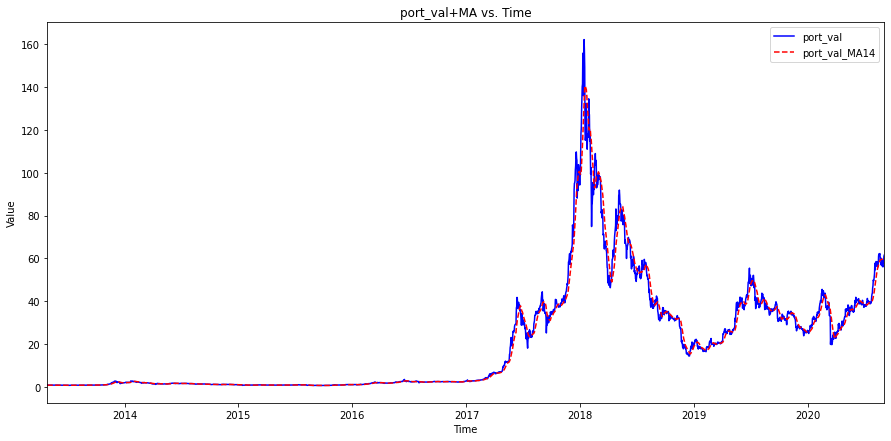

p-value = 0.0 The series port_val_RM_I is likely stationary.
(-inf, 0.0, array([-3.90052967, -3.33840999, -3.04603233]))


/Users/jorgecanedo/Desktop/algo_trading/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1712: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(


In [20]:
############
## TEST 1 ##
############

## Create normalized timeseries for portfolio
port_val = port_df['port_val']
port_rm = take_roll_avg(port_val, ROLL_WIND)
port_rm.name = f'{port_val.name}_RM'


### IF a random variable is stationary THEN it is also order one integratable ###
# if test_stationarity(port_rm):

port_ret = integrate(port_rm)


comparator = port_ret + np.random.normal(0, 5, len(port_ret))

# These two series should be stationary and cointegrate
coint_res = is_coint(port_ret, comparator)
print(coint_res)

In [21]:
############
## TEST 2 ##
############

col_1, col_2 = port_df.columns[:2]
s_1, s_2 = port_df[col_1], port_df[col_2]

# Random two series likely should not be stationary
coint_res = is_coint(s_1, s_2)
print(coint_res)

p-value = 2.336113500489693e-05 The series None is likely stationary.
(-3.6436895778632916, 0.021611108082342546, array([-3.90052967, -3.33840999, -3.04603233]))


<Figure size 432x288 with 0 Axes>

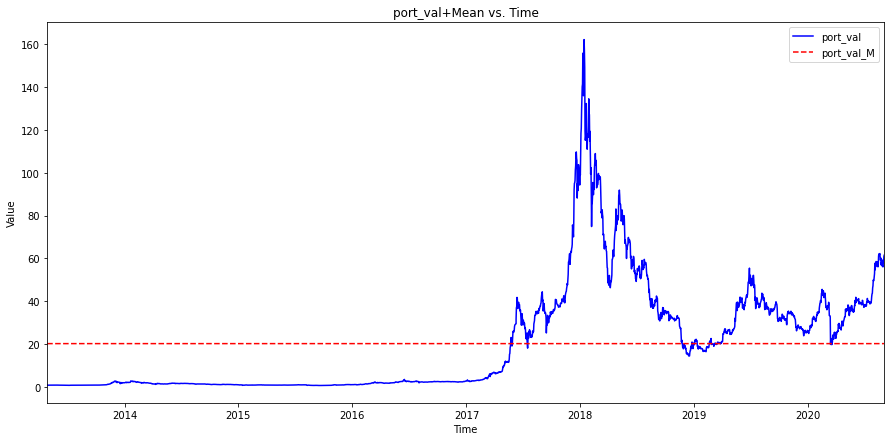

<Figure size 432x288 with 0 Axes>

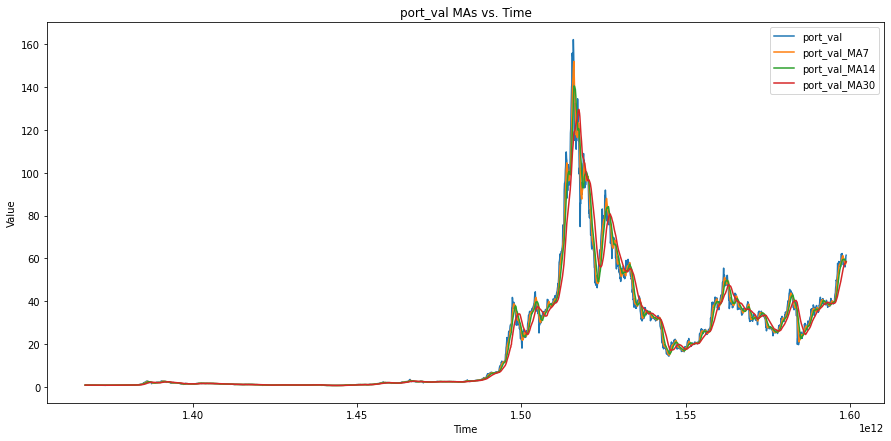

0.9345782997991644


In [22]:
take_mean(port_val)
df_feats = series_to_df_feats(port_val, LOOKBACKS, plot=True)

print(sharpe_ratio(df_feats['port_val_DR']))
